# AIM

Aim of this Notebook is to export the TL;DR and custom dataset to jsonl file so we can upload it in the colab and then use it for our finetuning and evalution

In [1]:
from pathlib import Path
import sys

project_root = Path.cwd().parent  # or Path().resolve().parent
sys.path.insert(0, str(project_root))
# we are doing this so we can import src folder

import re
import json
import regex
import numpy as np
import pandas as pd
from sqlite3 import connect
import matplotlib.pyplot as plt
from datasets import load_dataset
from src.load_dataset import load_jsonl
from src.utils.batch_utils import data_folder
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from src.load_dataset import CS_JSON, TL_DR_JSON, plt_tokens_for_dataset
from src.load_model import load_tokenizer, apply_formatter, format_dataset, TOKEN_LIMIT_FOR_CS

# Exporting the Custom Dataset

Custom Dataset is the dataset we collected from YouTube videos, where we asked YouTube with a search query and collected the transcripts of the top 4 possible videos. and then for each search query we asked the gpt 5.1 chat to summarize the transcripts into a concise summary.

you can find how we fetched the YouTube data from here: [fetch_custom_dataset.py](https://github.com/au-nlp/project-milestone-p2-group-6/blob/main/src/fetch_custom_dataset.py)
and how we prompted gpt 5.1 chat from here: [summary_for_custom_dataset.py](https://github.com/au-nlp/project-milestone-p2-group-6/blob/main/src/summary_for_custom_dataset.py)


we would now be exporting them to jsonl file

In [2]:
db = data_folder / "saved_videos.db"

In [3]:
db_conn = connect(str(db))

In [4]:
SYSTEM_PROMPT = "You summarize multiple video transcripts into concise, factual summaries."

def export_results():
    prompt_results = pd.read_sql("SELECT * FROM PromptResults where Response is NOT NULL", db_conn)
    samples = []

    for _row in prompt_results[["AgentPrompt", "Response"]].itertuples(index=False):
        samples.append({
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": _row[0]},
                {"role": "assistant", "content": _row[1]},
            ]
        })

    pd.DataFrame(samples).to_json(data_folder / CS_JSON, orient='records', lines=True)


In [6]:
export_results()

## Note

While fetching the Transcripts of the YouTube Video we have observed they have large transcript size and below we wanted to ensure the largest one in our training set should not exceed 10_000 tokens

In [8]:
tokenizer = load_tokenizer()
# we are loading tokenizer from llama 3b Model

# from the file we just exported we load it once
custom_dataset = load_jsonl(data_folder / CS_JSON)

formatter = apply_formatter(tokenizer, token_limit=TOKEN_LIMIT_FOR_CS)

# we then have the tokenized samples
tokenized_custom_dataset = format_dataset(formatter, custom_dataset, "Tokenizing Custom Dataset")


[1/8] Loading dataset...
✓ Loaded 1004 examples
Tokenizing Custom Dataset


Tokenizing Custom Dataset:   0%|          | 0/1004 [00:00<?, ? examples/s]

## Plot Token Lengths

we are now plotting the token lengths to see how many records are having more than 10,000 tokens

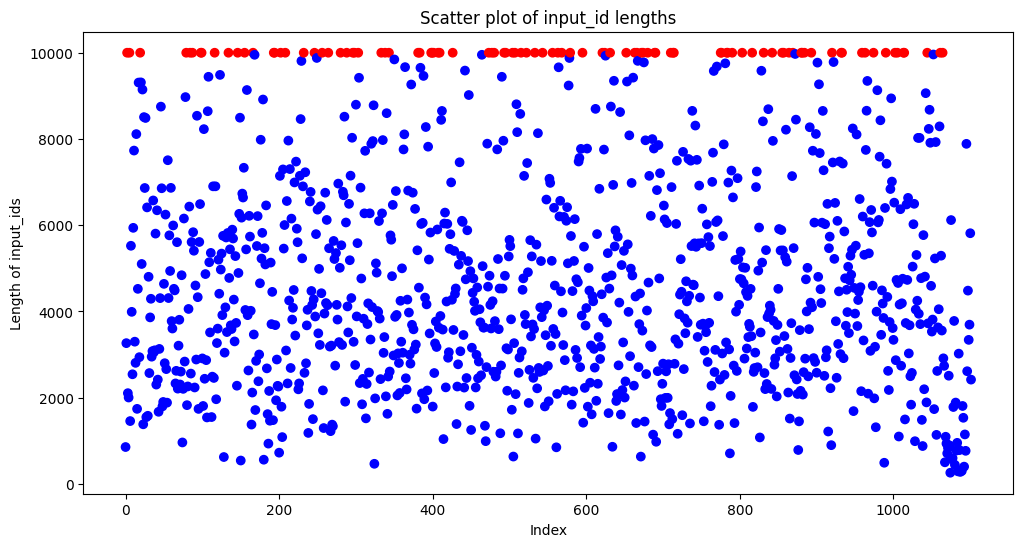

In [30]:
sie = []
note = []

for index, _ in enumerate(tokenized_custom_dataset):
    if len(_['input_ids']) == TOKEN_LIMIT_FOR_CS:
        note.append(index)
    sie.append(len(_['input_ids']))

# Create a color list: red if in note, blue otherwise
colors = ['red' if i in note else 'blue' for i in range(len(sie))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(sie)), sie, c=colors)
plt.xlabel("Index")
plt.ylabel("Length of input_ids")
plt.title("Scatter plot of input_id lengths")
plt.show()


In [31]:
"Loss: ", len(note)

('Loss: ', 98)

## Observation

we have observed 98 Records were exceeding the token limit of 10,000. we would be removing those 98 records

## Generate SQL Script

Since we are saving the Custom Dataset in sqlite we are generating the sql script to delete those records which are exceeding the token limit of 10,000

In [38]:
script = """"""
pattern = r"USER PROMPT:\s*([\s\S]*?)(?:\nVIDEO TRANSCRIPTS|\Z)"

for index in note:
    result = regex.findall(pattern, custom_dataset[index]["messages"][1]["content"])
    s_p = result[0].replace("'", "''")
    script += f"delete from `PromptResults` where SearchPrompt = '{s_p}';\n"

print(script)

delete from `PromptResults` where SearchPrompt = 'how to grow tomatoes in containers';
delete from `PromptResults` where SearchPrompt = 'why is nuclear waste dangerous';
delete from `PromptResults` where SearchPrompt = 'what is folk psychology';
delete from `PromptResults` where SearchPrompt = 'how to clean carburetor';
delete from `PromptResults` where SearchPrompt = 'why is methanol toxic';
delete from `PromptResults` where SearchPrompt = 'how to make fried rice perfectly';
delete from `PromptResults` where SearchPrompt = 'what is blockchain technology';
delete from `PromptResults` where SearchPrompt = 'why do wolves hunt in packs';
delete from `PromptResults` where SearchPrompt = 'how to make po boy sandwich';
delete from `PromptResults` where SearchPrompt = 'what is philosophical zombies';
delete from `PromptResults` where SearchPrompt = 'how to make french macarons';
delete from `PromptResults` where SearchPrompt = 'why do lanternfish have photophores';
delete from `PromptResults`

## After the Deletion

we are reloading the dataset and checking if there's still any records exceeding the token limit of 10,000

In [5]:
# Load JSONL data (Custom Dataset)
custom_dataset = load_jsonl(data_folder / CS_JSON)

# we are loading tokenizer from llama 3b Model
tokenizer = load_tokenizer()

# from the file we just exported we load it once
custom_dataset = load_jsonl(data_folder / CS_JSON)

formatter = apply_formatter(tokenizer, token_limit=TOKEN_LIMIT_FOR_CS)

# we then have the tokenized samples
tokenized_custom_dataset = format_dataset(formatter, custom_dataset, "Tokenizing Custom Dataset")


[1/8] Loading dataset...
✓ Loaded 1004 examples

[1/8] Loading dataset...
✓ Loaded 1004 examples
Tokenizing Custom Dataset


Tokenizing Custom Dataset:   0%|          | 0/1004 [00:00<?, ? examples/s]

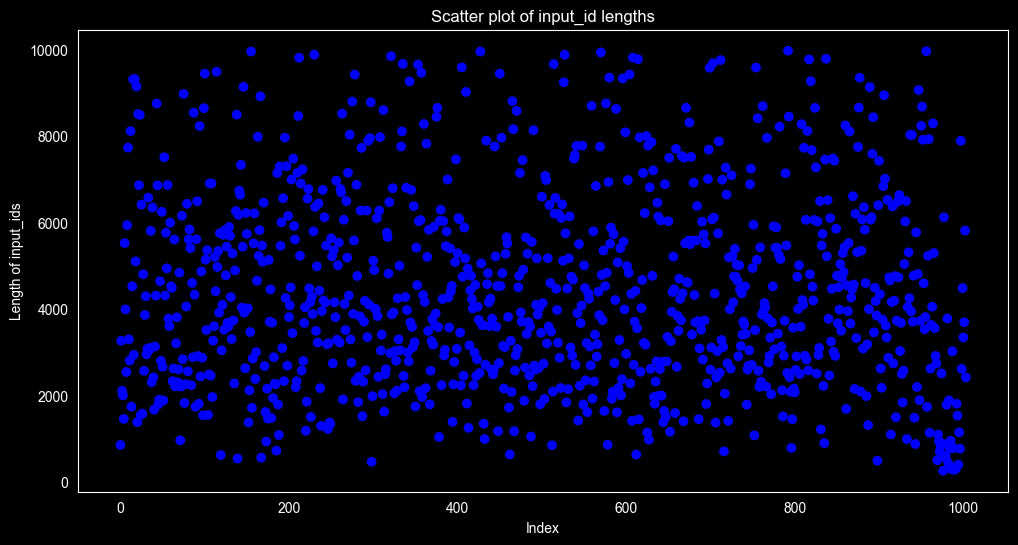

In [6]:
plt_tokens_for_dataset(tokenized_custom_dataset, limit=TOKEN_LIMIT_FOR_CS)

## Exporting results

now that we have filtered the samples from custom dataset which have more than 10_000 tokens we will now export results

In [7]:
export_results()

# Exporting the TL;DR Dataset

After Loading [TL;DR Dataset](https://huggingface.co/datasets/trl-lib/tldr), we would be first clustering the dataset based on the similarity of the post contents and then concating their tl;dr to form a dataset that's similar to our custom dataset.

Once done we would export it to jsonl file

but first we would preprocess the tl;dr dataset and then proceed with clustering

In [2]:
data_set = load_dataset("trl-lib/tldr")

In [3]:
ds = {}
# we would be using regex to extract the post content and title and subreddit
for set_type in data_set.keys():
    ds[set_type] = pd.DataFrame(data_set[set_type])
    ds[set_type]["prompt_post"] = ds[set_type].prompt.str.extract(
        r'POST: ((.|\n)*)\nTL;DR:', expand=False
    ).iloc[:, 0]
    ds[set_type]["prompt_title"] = ds[set_type].prompt.str.extract(
        r'TITLE: ((.|\n)*)\n\nPOST:', expand=False
    ).iloc[:, 0]
    ds[set_type]["subreddit"] = ds[set_type].prompt.str.extract(
        r'SUBREDDIT: ((.|\n)*)\n\nTITLE:', expand=False
    ).iloc[:, 0]

In [4]:
train_set = ds["train"]

# we are removing the word TL;DR from the post
train_set["prompt_post"] = train_set["prompt_post"].str.replace(r'\s*TL;DR:\s*', '', regex=True)

# remove leading spaces and tabs from the beginning of the text and also from the start of each new line
train_set["completion"] = [
    re.sub(r'\n[ \t]+', '\n', re.sub(r'^[ \t]+', '', t))
    for t in train_set["completion"]
]
print(train_set.columns)
print(train_set.iloc[1234]["prompt_post"])

Index(['prompt', 'completion', 'prompt_post', 'prompt_title', 'subreddit'], dtype='object')
My 25 year old son has a job which means he does 12 hour nightshifts 3-4 times a week, including weekends. After his nightshifts, he comes to my house an sleeps in the spare bedroom. He sleeps in my house because he says at his own house, it's too noisy. 

In his own house, he has his partner, who is mostly home during weekdays as she only works weekends. They then have a one year old, then his partner has a 14 year old girl who - if it's the weekends or after school, always has at least 2 friends with her. It's the group of girls who are the noisiest. So the house is very noisy. 

I don't have a problem with my son sleeping in my spare room, but I think as his mother I should try and encourage him to have a better arrangement set up in his own home so he can sleep there, for his sake. For example, if the 14 year old does have friends over, she could only have them downstairs, and they'd not be 

In [5]:
# Separate AskReddit from other subreddits
askreddit_df = train_set[train_set['subreddit'] == 'r/AskReddit']
other_df = train_set[train_set['subreddit'] != 'r/AskReddit']

# Downsample other subreddits to max 2000 each
downsampled_other = other_df.groupby('subreddit', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 2000), random_state=42)
)

# Combine back together
train_set = pd.concat([askreddit_df, downsampled_other], ignore_index=True)
train_set = train_set.sample(frac=1, random_state=42).reset_index(drop=True)
# print(train_set['subreddit'].value_counts())

/var/folders/5z/ksmd9z810hv7hd63k2mmtgzr0000gn/T/ipykernel_8676/1256756349.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  downsampled_other = other_df.groupby('subreddit', group_keys=False).apply(


## Note

we are removing duplicate posts from the dataset, we have observed the duplicate posts (same post) posted in multiple subreddits

In [6]:
# before dropping
print(len(train_set))

train_set = train_set.drop_duplicates(["prompt_post"])

# after dropping duplicates
print(len(train_set))

41773
41601


## Clustering

we would be clustering the posts using cosine similarity

In [8]:
tfidf = TfidfVectorizer()
# converting the posts to TF-IDF Matrix
tfidf_mat = tfidf.fit_transform(train_set["prompt_post"])
print(tfidf_mat.shape)

(41601, 62384)


In [9]:
# clustering algo. for posts
def knn_greedy_clustering(tfidf_matrix, min_size=2, max_size=4,
                          threshold=0.7, n_neighbors=20):
    """
    Use k-NN for fast neighbor finding, then greedy cluster formation
    """
    n = tfidf_matrix.shape[0]

    # Fit k-NN model (cosine similarity)
    nbrs = NearestNeighbors(n_neighbors=min(n_neighbors + 1, n),  # +1 for self
                            metric='cosine',
                            algorithm='auto')
    nbrs.fit(tfidf_matrix)

    # Get neighbors for all samples at once
    distances, indices = nbrs.kneighbors(tfidf_matrix)
    similarities = 1 - distances  # Convert distance to similarity

    # Greedy clustering using precomputed neighbors
    assigned = np.zeros(n, dtype=bool)
    clusters = []

    # Process in order of maximum similarity (samples with strong matches first)
    max_sims = similarities[:, 1].copy()  # Skip self (index 0)
    order = np.argsort(max_sims)[::-1]

    for idx in order:
        if assigned[idx]:
            continue

        cluster = [int(idx)]  # Convert to Python int immediately

        # Add neighbors that are unassigned and above threshold
        # Start from index 1 to skip self (index 0 is always the sample itself)
        for neighbor_idx, sim in zip(indices[idx][1:], similarities[idx][1:]):
            neighbor_idx = int(neighbor_idx)  # Convert to Python int

            # if the post's similarity is above 95% we are discarding them
            # since they might be from the same ones but across subreddits
            if neighbor_idx != idx and not assigned[neighbor_idx] and sim >= threshold and sim < 0.95:
                cluster.append(neighbor_idx)
                if len(cluster) >= max_size:
                    break

        # Only add cluster if it meets minimum size
        if len(cluster) >= min_size:
            clusters.append(cluster)
            assigned[cluster] = True
        # If cluster too small, leave sample unassigned for now

    return clusters, assigned


# Usage
clusters, assigned = knn_greedy_clustering(
    tfidf_mat,
    min_size=2,
    max_size=4,
    threshold=0.3,
    n_neighbors=50
)

# Verify no single-element clusters
print(f"Any size-1 clusters? {any(len(c) == 1 for c in clusters)}")
print(f"Clustered: {assigned.sum()} / {len(assigned)}")
print(f"Unassigned: {(~assigned).sum()}")

Any size-1 clusters? False
Clustered: 20487 / 41601
Unassigned: 21114


In [10]:
cluster_sizes = [len(c) for c in clusters]
unique, counts = np.unique(cluster_sizes, return_counts=True)

print("Cluster size distribution:")
for size, count in zip(unique, counts):
    print(f"  Size {size}: {count} clusters")

Cluster size distribution:
  Size 2: 3121 clusters
  Size 3: 1047 clusters
  Size 4: 2776 clusters


In [11]:
print(clusters[0])

[38596, 21353, 29682, 16046]


In [12]:
print(train_set['completion'].iloc[36376])
#print(train_set['completion'].iloc[34728])
print(train_set['completion'].iloc[18913])
print(train_set['completion'].iloc[6146])

hit a careless jaywalker at around 20mph going thru an intersection on my green. I drove abiding all traffic laws. What can be the outcome?
2 jobs, the first $65k train driver or $?? IT position with no formal job title yet but he did mention working under him as an admin assistant.
I need a new laptop and I might be fed up with Windows. Show me what's best all around without any specific criteria.


In [13]:
print(train_set["prompt_post"].iloc[11304])
print(train_set["prompt_post"].iloc[7008])

Wow, there really is a subreddit for everything. Ok well if someone who knows about this could help me out i would appreciate it.

I few month ago I heard about how Ireland adopted A.C.T.A ( or was it sopa?) anyway just wile skimming and article I heard that this gave them the right to search mp3 players, ipods, and laptops for pirated music in the same way they can search your bag for drugs. now i didn't pay attention to the credibility of the source at the time because i hadn't seen going to Ireland in the foreseeable future but something has come up and I am headed there this December. If this is true it will mean the difference between be bringing my ipod and laptop or not.

I have been doing some research but it is the internet and its difficult to find a credible answer to any obscure question like this.

So this guy was my friend in college. I am really good friends with his girlfriend and to make a long story short we betrayed him and we had sex. So she feels really bad about t

## Prep. the Dataset

we would be creating the new dataset based on the clusters and the prepends (we prepared few prepend templates refer them from here: [tldr_prepend.py](https://github.com/au-nlp/project-milestone-p2-group-6/blob/main/src/tldr_prepend.py))

In [97]:
# Go one directory up from notebook location
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
# Add to path
sys.path.append(str(project_root))
from src.tldr_prepend import Prepends

processed = {"transscript": [], "TLDR": []}
prep = Prepends()

for i, group in enumerate(clusters):
    processed["TLDR"].append("")
    processed["transscript"].append("")
    for i, text_idx in enumerate(group):
        processed["TLDR"][-1] += f"{prep.get_random_prepend(i + 1)}\n{train_set['completion'].iloc[text_idx]}\n\n"
        # format transscripts
        processed["transscript"][-1] += f"TITLE_OF_VIDEO_{i + 1}: {train_set['prompt_title'].iloc[text_idx]}\n"
        processed["transscript"][
            -1] += f"TRANSCRIPT_OF_VIDEO_RESULT_{i + 1}: {train_set['prompt_post'].iloc[text_idx]}\n"

processed_df = pd.DataFrame(processed)


In [ ]:
print(len(processed_df))

6944


In [101]:
print(processed_df["transscript"][587])

TITLE_OF_VIDEO_1: Reddit, My family is being evicted in 22 days, by my uncle who falsely gotten his name on my grandfather's trust/will. We have virtually no money to get a lawyer. What do we do? (More info inside)[X-post from askreddit]
TRANSCRIPT_OF_VIDEO_RESULT_1: **I just copy and pasted this out of the Ask-Reddit section, as it was suggested i post here, too**

Okay, basically, my uncle had his name put on all of my grandpa's stuff (i.e. Banks, trust, will...etc) because my grandpa is getting old, and its just what people do. Anyways he decided to turn himself into 'God' and sell both the houses his name was on.

I know i didn't explain this before, but my grandpa gave my mom this house, and now my uncle's name is on it.
So, This is VERY long and hard to explain whats going on, so i'll just sum it up. My uncle got his lawyers** using my grandpa's money** to send us a eviction notice, and after 72 hours, the police will get involved. He already did this to my other uncle, so we kno

In [85]:
len(processed_df)

6944

In [84]:
SYSTEM_PROMPT = "You summarize multiple video transcripts into concise, factual summaries."

with open(data_folder / TL_DR_JSON, "w", encoding="utf-8") as f:
    for _, row in processed_df.iterrows():
        example = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": row["transscript"]},
                {"role": "assistant", "content": row["TLDR"]},
            ]
        }
        f.write(json.dumps(example, ensure_ascii=False) + "\n")


* [X] Exported Custom Dataset to `../data/custom_dataset.jsonl`
* [X] Exported TL;DR Dataset to `../data/proc_tldr.jsonl`